## Preparing the dataset

In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping
import os

Raster

In [2]:
sentinal_fp = "data2/sentinel-2/"
# find every file in the sentinal_fp directory
sentinal_band_paths = [os.path.join(sentinal_fp, f) for f in os.listdir(sentinal_fp) if os.path.isfile(os.path.join(sentinal_fp, f))]
sentinal_band_paths.sort()
sentinal_band_paths

['data2/sentinel-2/2018-10-13, Sentinel-2B L1C, B01.tiff',
 'data2/sentinel-2/2018-10-13, Sentinel-2B L1C, B02.tiff',
 'data2/sentinel-2/2018-10-13, Sentinel-2B L1C, B03.tiff',
 'data2/sentinel-2/2018-10-13, Sentinel-2B L1C, B04.tiff',
 'data2/sentinel-2/2018-10-13, Sentinel-2B L1C, B05.tiff',
 'data2/sentinel-2/2018-10-13, Sentinel-2B L1C, B06.tiff',
 'data2/sentinel-2/2018-10-13, Sentinel-2B L1C, B07.tiff',
 'data2/sentinel-2/2018-10-13, Sentinel-2B L1C, B08.tiff']

In [3]:
img_dir = 'data2/products/'

# check to see if the dir it exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# filepath for image we're writing out
img_fp = img_dir + 'sentinel_bands.tif'

# Read metadata of first file and assume all other bands are the same
with rasterio.open(sentinal_band_paths[0]) as src0:
    meta = src0.meta

# Update metadata to reflect the number of layers
meta.update(count = len(sentinal_band_paths))

# Read each layer and write it to stack
with rasterio.open(img_fp, 'w', **meta) as dst:
    for id, layer in enumerate(sentinal_band_paths, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [4]:
full_dataset = rasterio.open(img_fp)
img_rows, img_cols = full_dataset.shape
img_bands = full_dataset.count
print(full_dataset.shape,"dimensions")
print(full_dataset.count,"band")

(2201, 2629) dimensions
8 band


(3, 450, 1150)


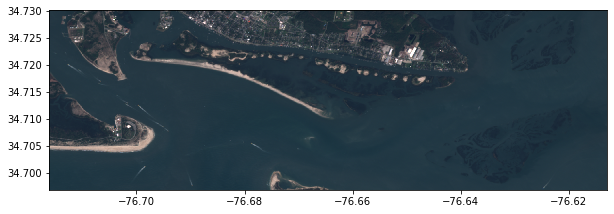

In [5]:
import matplotlib.pyplot as plt
from rasterio.plot import show

clipped_img = full_dataset.read([4,3,2])[:, 150:600, 250:1400]
print(clipped_img.shape)
fig, ax = plt.subplots(figsize=(10,7))
show(clipped_img[:, :, :], ax=ax, transform=full_dataset.transform) # add the transform arg to get it in lat long coords

In [6]:
full_dataset.crs

CRS.from_dict(init='epsg:4326')

Vector

In [7]:
shapefile = gpd.read_file("data2/rcr/rcr_landcover_Project.shp")
shapefile.crs

{'init': 'epsg:4326'}

In [8]:
len(shapefile)

23

In [9]:
# this generates a list of shapely geometries
geoms = shapefile.geometry.values 

# let's grab a single shapely geometry to check
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] # can also do this using polygon.__geo_interface__
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((-76.67593927899998 34.69487548800004, -76.67573882799996 34.69451319900003, -76.67666934599998 34.69360077400006, -76.67676946199998 34.69421769400003, -76.67593927899998 34.69487548800004))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((-76.67593927899998, 34.69487548800004), (-76.67573882799996, 34.69451319900003), (-76.67666934599998, 34.69360077400006), (-76.67676946199998, 34.69421769400003), (-76.67593927899998, 34.69487548800004)),)}]


In [10]:
out_image, out_transform = mask(full_dataset, feature, crop=True)
out_image.shape

(8, 18, 13)

In [11]:
full_dataset.close()

## Building the Training Data

In [12]:
X = np.array([], dtype=np.int8).reshape(0,8) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

# extract the raster values within the polygon 
with rasterio.open(img_fp) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all 8 bands - AKA not actually part of the shapefile
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shapefile["Classname"][index]] * out_image_reshaped.shape[0]) 
        # stack the pizels onto the pixel array
        X = np.vstack((X,out_image_reshaped))

In [13]:
# What are our classification labels?
labels = np.unique(shapefile["Classname"])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size,classes=labels))

# We will need a "X" matrix containing our features, and a "y" array containing our labels
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 6 classes: ['Emergent Wetland' 'Forested Wetland' 'Herbaceous' 'Sand'
 'Subtidal Haline' 'WetSand']

Our X matrix is sized: (598, 8)
Our y array is sized: (598,)


Text(0.5, 1.0, 'Band Intensities Higher Ref Subset')

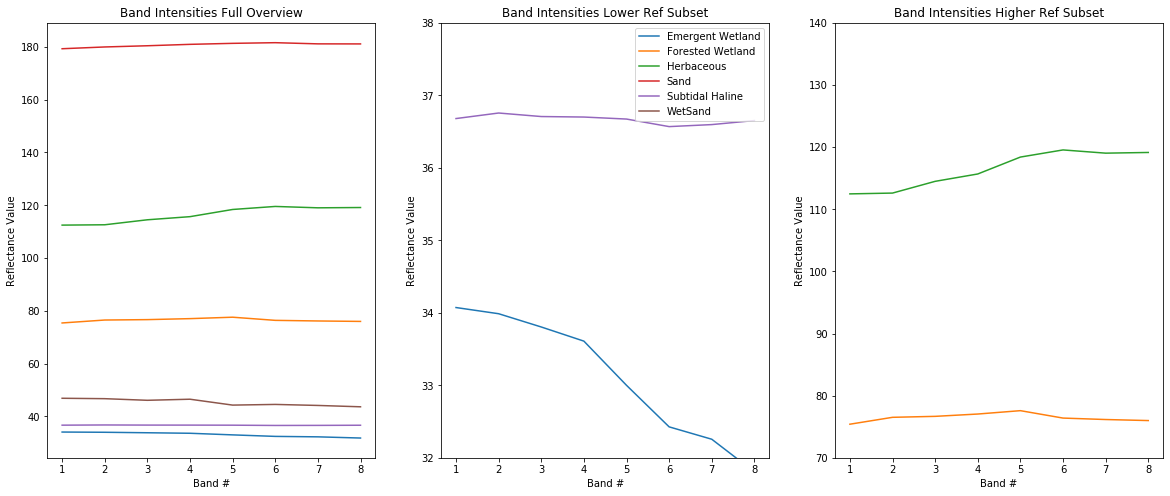

In [14]:
fig, ax = plt.subplots(1,3, figsize=[20,8])

# numbers 1-8
band_count = np.arange(1,9)

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    ax[0].plot(band_count, band_intensity, label=class_type)
    ax[1].plot(band_count, band_intensity, label=class_type)
    ax[2].plot(band_count, band_intensity, label=class_type)
# plot them as lines

# Add some axis labels
ax[0].set_xlabel('Band #')
ax[0].set_ylabel('Reflectance Value')
ax[1].set_ylabel('Reflectance Value')
ax[1].set_xlabel('Band #')
ax[2].set_ylabel('Reflectance Value')
ax[2].set_xlabel('Band #')
#ax[0].set_ylim(32,38)
ax[1].set_ylim(32,38)
ax[2].set_ylim(70,140)
#ax.set
ax[1].legend(loc="upper right")
# Add a title
ax[0].set_title('Band Intensities Full Overview')
ax[1].set_title('Band Intensities Lower Ref Subset')
ax[2].set_title('Band Intensities Higher Ref Subset')

In [15]:
def str_class_to_int(class_array):
    class_array[class_array == 'Subtidal Haline'] = 0
    class_array[class_array == 'WetSand'] = 1
    class_array[class_array == 'Emergent Wetland'] = 2
    class_array[class_array == 'Sand'] = 3
    class_array[class_array == 'Herbaceous'] = 4
    class_array[class_array == 'Forested Wetland'] = 5
    return(class_array.astype(int))

## Training the Classifier (Naive Bayes)

In [16]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [24]:
from sklearn.ensemble import RandomForestClassifier
gnb = RandomForestClassifier(n_estimators=500,oob_score=True)
gnb = gnb.fit(X,y)

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
gnb = GradientBoostingClassifier()
gnb = gnb.fit(X,y)

In [45]:
import xgboost as xgb
gnb = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
gnb = gnb.fit(X, y)

In [52]:
from sklearn.neural_network import MLPClassifier
gnb = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)
gnb = gnb.fit(X,y)

C:\Users\attawut\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [64]:
from sklearn import svm
gnb = svm.SVC(decision_function_shape='ovo')
gnb = gnb.fit(X,y)

## Predicting on the image

In [32]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster, reshape_as_image

In [65]:
with rasterio.open(img_fp) as src:
    # may need to reduce this image size if your kernel crashes, takes a lot of memory
    img = src.read()[:, 150:600, 250:1400]

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
print(img.shape)
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(8, 450, 1150)
(450, 1150, 8)


In [66]:
class_prediction = gnb.predict(reshaped_img.reshape(-1, 8))

# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_img[:, :, 0].shape)

In [67]:
class_prediction = str_class_to_int(class_prediction)

## visualize

In [68]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors
    
# find the highest pixel value in the prediction image
n = int(np.max(class_prediction))

# next setup a colormap for our map
colors = dict((
    (0, (48, 156, 214, 255)),   # Blue - Water
    (1, (139,69,19, 255)),      # Brown - WetSand
    (2, (96, 19, 134, 255)),    # Purple - Emergent Wetland
    (3, (244, 164, 96, 255)),   # Tan - Sand
    (4, (206, 224, 196, 255)),  # Lime - Herbaceous
    (5, (34, 139, 34, 255)),    # Forest Green - Forest 
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(0, n+1)]

cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n+1)

C:\Users\attawut\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


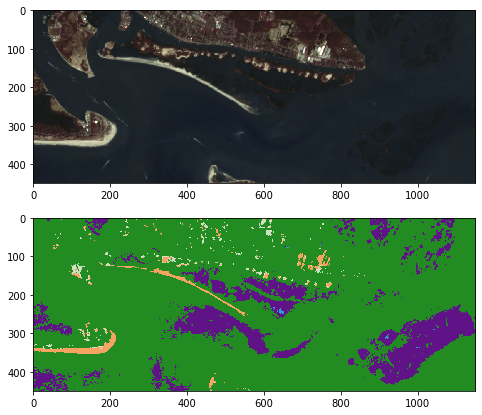

In [69]:
fig, axs = plt.subplots(2,1,figsize=(10,7))

img_stretched = color_stretch(reshaped_img, [4, 3, 2])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction, cmap=cmap, interpolation='none')

fig.show()